`Задание 0` <br> Выбрать любую модель машинного обучения и зафиксировать любой тип валидации. Обучить базовую модель и зафиксировать базовое качество модели. В каждом следующем задании нужно будет обучить выбранную модель и оценивать ее качество на зафиксированной схеме валидации. После каждого задания, требуется сделать вывод о достигаемом качестве модели, по сравнению с качестом из предыдущего шага.

In [77]:
import pandas as pd
import numpy as np
import time
import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance

import xgboost as xgb
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('/mnt/f/data/kg/HW2/assignment_train.csv')

In [3]:
x_train, x_valid = train_test_split(data.drop(["isFraud"], axis=1), train_size=0.7, random_state=1)
y_train, y_valid = train_test_split(data["isFraud"], train_size=0.7, random_state=1)

In [4]:
xgb_params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "nthread": 6,
    "seed": 27
}

In [5]:
numeric = data.select_dtypes(exclude="object").drop("isFraud", axis=1).columns

In [6]:
dtrain = xgb.DMatrix(x_train[numeric], y_train)
dvalid = xgb.DMatrix(x_valid[numeric], y_valid)

model = xgb.train(
    dtrain=dtrain,
    params=xgb_params,
    num_boost_round=500,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=20,
    verbose_eval=10,
)

[12:49:04] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.81297	valid-auc:0.78768
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[10]	train-auc:0.84450	valid-auc:0.82188
[20]	train-auc:0.87890	valid-auc:0.85383
[30]	train-auc:0.90896	valid-auc:0.88494
[40]	train-auc:0.93285	valid-auc:0.89729
[50]	train-auc:0.95129	valid-auc:0.90514
[60]	train-auc:0.96291	valid-auc:0.90886
[70]	train-auc:0.96957	valid-auc:0.91265
[80]	train-auc:0.97298	valid-auc:0.91491
[90]	train-auc:0.97556	valid-auc:0.91652
[100]	train-auc:0.97835	valid-auc:0.91765
[110]	train-auc:0.98061	valid-auc:0.91899
[120]	train-auc:0.98247	valid-au

`Задание 1` <br> Признак TransactionDT - это смещение в секундах относительно базовой даты. Базовая дата - 2017-12-01, преобразовать признак TransactionDT в datetime, прибавив к базовой дате исходное значение признака. Из полученного признака выделить год, месяц, день недели, час, день.


In [7]:
BASE_DATE_UNIX = time.mktime(datetime.date(2017, 12, 1).timetuple())

In [8]:
data['NewTransactionDT'] = pd.to_datetime(data.TransactionDT + BASE_DATE_UNIX, unit='s')

In [9]:
data['hour'] = data.NewTransactionDT.dt.hour
data['day'] = data.NewTransactionDT.dt.day
data['month'] = data.NewTransactionDT.dt.month
data['year'] = data.NewTransactionDT.dt.year
data['weekday'] = data.NewTransactionDT.dt.weekday

In [10]:
ex1 = numeric.tolist() + ['hour', 'day', 'month', 'year', 'weekday']

In [11]:
x_train, x_valid = train_test_split(data.drop(["isFraud"], axis=1), train_size=0.7, random_state=1)
y_train, y_valid = train_test_split(data["isFraud"], train_size=0.7, random_state=1)

dtrain = xgb.DMatrix(x_train[ex1], y_train)
dvalid = xgb.DMatrix(x_valid[ex1], y_valid)

model = xgb.train(
    dtrain=dtrain,
    params=xgb_params,
    num_boost_round=500,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=20,
    verbose_eval=10,
)

[12:49:33] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.81297	valid-auc:0.78768
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[10]	train-auc:0.84588	valid-auc:0.81989
[20]	train-auc:0.87899	valid-auc:0.85321
[30]	train-auc:0.91059	valid-auc:0.88448
[40]	train-auc:0.93464	valid-auc:0.89513
[50]	train-auc:0.95365	valid-auc:0.90279
[60]	train-auc:0.96391	valid-auc:0.90741
[70]	train-auc:0.96942	valid-auc:0.91116
[80]	train-auc:0.97255	valid-auc:0.91461
[90]	train-auc:0.97543	valid-auc:0.91596
[100]	train-auc:0.97800	valid-auc:0.91713
[110]	train-auc:0.97965	valid-auc:0.91946
[120]	train-auc:0.98237	valid-au

Добавление данных признаков не дало прироста в качестве на валидации.

`Задание 2` <br>
Сгруппировать данные по `card1` и посчитать среднюю сумму транзакции. Добавить в качестве признака в набор данных. Посчитать разницу между суммой транзакцией пользователя и средней суммой транзакции по данному типу `card1`. Построить отношение этих признаков. Повторить процедуру для всех `card`.

In [12]:
card_features = data.columns[data.columns.str.contains('card')]

In [13]:
for feat in card_features:
    print(f'{feat} has NaNs: {data[feat].isna().any()}')

card1 has NaNs: False
card2 has NaNs: True
card3 has NaNs: True
card4 has NaNs: True
card5 has NaNs: True
card6 has NaNs: True


In [14]:
data.card2 = data.card2.fillna(data.card2.median())
data.card3 = data.card3.fillna(data.card3.median())
data.card4 = data.card4.fillna('unknown')
data.card5 = data.card5.fillna(data.card5.median())
data.card6 = data.card6.fillna('unknown')

In [15]:
def get_mean_by_group(df: pd.DataFrame, by: str, col: str) -> pd.DataFrame:
    mean_values = df.groupby(by).mean().reset_index()[[by, col]]
    mean_values[col].fillna('mean', inplace=True)
    mean_values.columns = [by, f'Mean{col}_{by}']
    return mean_values

In [16]:
for feat in card_features:
    data = data.merge(get_mean_by_group(data, feat, 'TransactionAmt'), how='left', on=feat)

In [17]:
new_card_features = data.columns[data.columns.str.contains('card')].drop(card_features)

In [18]:
new_card_features

Index(['MeanTransactionAmt_card1', 'MeanTransactionAmt_card2',
       'MeanTransactionAmt_card3', 'MeanTransactionAmt_card4',
       'MeanTransactionAmt_card5', 'MeanTransactionAmt_card6'],
      dtype='object')

In [19]:
def get_mean_ratio(df: pd.DataFrame, amt_col: str, mean_col: str) -> pd.Series:
    return (data[amt_col] - data[mean_col]) / data[mean_col]

In [20]:
for new_feat in new_card_features:
    prefix = new_feat.split('_')[-1]
    data[f'{prefix}_mean_diff_ratio'] = get_mean_ratio(data, 'TransactionAmt', new_feat)

In [21]:
data.columns[data.columns.str.contains('ratio')].tolist()

['card1_mean_diff_ratio',
 'card2_mean_diff_ratio',
 'card3_mean_diff_ratio',
 'card4_mean_diff_ratio',
 'card5_mean_diff_ratio',
 'card6_mean_diff_ratio']

In [22]:
new_card_features

Index(['MeanTransactionAmt_card1', 'MeanTransactionAmt_card2',
       'MeanTransactionAmt_card3', 'MeanTransactionAmt_card4',
       'MeanTransactionAmt_card5', 'MeanTransactionAmt_card6'],
      dtype='object')

In [23]:
ex2 = numeric.tolist() + new_card_features.tolist() + data.columns[data.columns.str.contains('ratio')].tolist()

In [24]:
x_train, x_valid = train_test_split(data.drop(["isFraud"], axis=1), train_size=0.7, random_state=1)
y_train, y_valid = train_test_split(data["isFraud"], train_size=0.7, random_state=1)

dtrain = xgb.DMatrix(x_train[ex2], y_train)
dvalid = xgb.DMatrix(x_valid[ex2], y_valid)

model = xgb.train(
    dtrain=dtrain,
    params=xgb_params,
    num_boost_round=500,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=20,
    verbose_eval=10,
)

[12:49:57] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.81640	valid-auc:0.79119
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[10]	train-auc:0.84034	valid-auc:0.81723
[20]	train-auc:0.88073	valid-auc:0.86068
[30]	train-auc:0.92279	valid-auc:0.89444
[40]	train-auc:0.94634	valid-auc:0.90579
[50]	train-auc:0.95842	valid-auc:0.91122
[60]	train-auc:0.96600	valid-auc:0.91342
[70]	train-auc:0.97128	valid-auc:0.91711
[80]	train-auc:0.97604	valid-auc:0.92103
[90]	train-auc:0.97909	valid-auc:0.92353
[100]	train-auc:0.98239	valid-auc:0.92481
[110]	train-auc:0.98406	valid-auc:0.92578
[120]	train-auc:0.98578	valid-au

С данными признаками качество на валидации несколько повысилось.

`Задание 3` <br>
Преобразовать признаки card_1 - card_6 с помощью Frequency Encoding

In [25]:
for feat in card_features:
    freq_encoder = data[feat].value_counts(normalize=True)
    data[f'{feat}_freq_encoded'] = data[feat].map(freq_encoder)

In [26]:
ex3 = numeric.tolist() + data.columns[data.columns.str.contains('encoded')].tolist()

In [27]:
x_train, x_valid = train_test_split(data.drop(["isFraud"], axis=1), train_size=0.7, random_state=1)
y_train, y_valid = train_test_split(data["isFraud"], train_size=0.7, random_state=1)

dtrain = xgb.DMatrix(x_train[ex3], y_train)
dvalid = xgb.DMatrix(x_valid[ex3], y_valid)

model = xgb.train(
    dtrain=dtrain,
    params=xgb_params,
    num_boost_round=500,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=20,
    verbose_eval=10,
)

[12:50:15] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.81751	valid-auc:0.78861
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[10]	train-auc:0.84051	valid-auc:0.81965
[20]	train-auc:0.88128	valid-auc:0.85841
[30]	train-auc:0.92014	valid-auc:0.88793
[40]	train-auc:0.94305	valid-auc:0.90328
[50]	train-auc:0.95593	valid-auc:0.90726
[60]	train-auc:0.96416	valid-auc:0.91054
[70]	train-auc:0.96959	valid-auc:0.91352
[80]	train-auc:0.97387	valid-auc:0.91662
[90]	train-auc:0.97674	valid-auc:0.91867
[100]	train-auc:0.97952	valid-auc:0.91995
[110]	train-auc:0.98196	valid-auc:0.92173
[120]	train-auc:0.98363	valid-au

Данные признаки не дали прироста в качестве.

`Задание 4` <br>
Преобразовать признак TransactionAmt в логарифм признака, выделить дробную часть и целую часть в отдельные признаки.

In [28]:
data['LogTransactionAmt'] = np.log(data.TransactionAmt)

In [44]:
data['LogFractionalTransactionAmt'], data['LogIntegralTransactionAmt']  = np.modf(data.LogTransactionAmt)

In [46]:
ex4 = numeric.tolist() + ['LogTransactionAmt', 'LogFractionalTransactionAmt', 'LogIntegralTransactionAmt']

In [47]:
x_train, x_valid = train_test_split(data.drop(["isFraud"], axis=1), train_size=0.7, random_state=1)
y_train, y_valid = train_test_split(data["isFraud"], train_size=0.7, random_state=1)

dtrain = xgb.DMatrix(x_train[ex4], y_train)
dvalid = xgb.DMatrix(x_valid[ex4], y_valid)

model = xgb.train(
    dtrain=dtrain,
    params=xgb_params,
    num_boost_round=500,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=20,
    verbose_eval=10,
)

[12:54:55] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.81297	valid-auc:0.78768
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[10]	train-auc:0.84410	valid-auc:0.82207
[20]	train-auc:0.87620	valid-auc:0.85379
[30]	train-auc:0.91136	valid-auc:0.88692
[40]	train-auc:0.93490	valid-auc:0.89732
[50]	train-auc:0.95281	valid-auc:0.90526
[60]	train-auc:0.96000	valid-auc:0.90850
[70]	train-auc:0.96682	valid-auc:0.91288
[80]	train-auc:0.97055	valid-auc:0.91527
[90]	train-auc:0.97440	valid-auc:0.91706
[100]	train-auc:0.97757	valid-auc:0.91806
[110]	train-auc:0.97933	valid-auc:0.91993
[120]	train-auc:0.98132	valid-au

Данные признаки не дали прироста.

`Задание 5` <br>
Для числовых признаков построить PCA-признаки, добавить их к основной части датасета.

In [51]:
scaler = MinMaxScaler()

In [56]:
numeric_data_rescaled = np.nan_to_num(scaler.fit_transform(data[numeric]))

In [57]:
pca = PCA(n_components = 0.95)
pca.fit(numeric_data_rescaled)
reduced = pca.transform(numeric_data_rescaled)

In [60]:
reduced.shape

(50001, 37)

In [62]:
pca_cols = [f'pca_comp_{i + 1}' for i in range(reduced.shape[1])]

In [65]:
pca_feats = pd.DataFrame(reduced, columns=pca_cols)

In [66]:
pca_feats

,pca_comp_1,pca_comp_2,pca_comp_3,pca_comp_4,pca_comp_5,pca_comp_6,pca_comp_7,pca_comp_8,pca_comp_9,pca_comp_10,...,pca_comp_28,pca_comp_29,pca_comp_30,pca_comp_31,pca_comp_32,pca_comp_33,pca_comp_34,pca_comp_35,pca_comp_36,pca_comp_37
0,-0.448290,0.118089,-0.829621,0.123170,-0.870317,0.316176,-0.159314,0.003322,0.354754,-0.210481,...,0.000266,-0.016541,-0.034675,-0.044837,0.047133,-0.030688,0.031893,0.003632,-0.139471,-0.015347
1,-0.429116,-0.477001,0.117416,-0.484874,-0.467635,-0.311322,0.347840,-0.004052,0.253741,-0.248502,...,0.015045,0.036552,0.009151,-0.000748,-0.010747,0.002280,-0.064831,0.010892,0.055379,0.069832
2,-1.001694,0.454697,-0.302933,0.084389,-0.655174,0.121912,0.559673,-0.301947,0.021730,-0.185675,...,-0.133241,-0.023098,-0.020894,0.009359,0.005069,-0.004293,0.028928,0.037079,-0.108385,-0.006223
3,-0.652390,-0.248912,0.033116,-0.525432,-0.270255,-0.488559,0.348090,-0.260415,0.841362,-0.150946,...,0.112022,0.611581,-0.000345,-0.300995,0.183946,0.125365,-0.277122,0.114593,-0.142233,-0.053720
4,1.978311,0.336832,-0.110268,-0.437020,-0.491395,0.153819,0.457403,-0.116508,0.394048,-0.157278,...,-0.009947,0.021506,0.046290,0.005213,0.014767,-0.042830,0.170834,0.074464,0.172753,-0.269234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49996,1.286510,-0.372167,-0.180067,0.908053,0.633950,-0.234030,-0.104473,-0.186752,0.153131,0.142003,...,0.008245,-0.005277,-0.041161,0.010978,0.026186,-0.012555,-0.009895,0.004034,0.001625,-0.018431
49997,-0.505236,-0.086761,0.453614,0.012628,0.386921,-0.556890,-0.355223,0.395926,-0.325108,0.078819,...,0.001752,0.017897,-0.010823,-0.021716,0.005462,-0.015317,0.094297,0.068122,-0.065191,-0.037271
49998,-0.334439,-0.752569,1.698128,0.448838,-0.217243,0.273553,-0.413614,-0.312511,0.168259,-0.584717,...,0.099804,-0.389674,-0.119595,0.341733,-0.079213,0.028512,0.024260,0.049768,0.127286,-0.151687
49999,1.277914,-0.460006,-0.124791,0.945504,0.426738,-0.148474,-0.136491,0.363417,0.203290,0.078346,...,-0.004364,-0.010176,-0.005409,0.012395,0.033515,-0.013624,-0.017233,-0.004300,0.000965,-0.031161


In [70]:
data = pd.concat([data, pca_feats], axis=1)

In [71]:
ex5 = numeric.tolist() + pca_cols

In [72]:
x_train, x_valid = train_test_split(data.drop(["isFraud"], axis=1), train_size=0.7, random_state=1)
y_train, y_valid = train_test_split(data["isFraud"], train_size=0.7, random_state=1)

dtrain = xgb.DMatrix(x_train[ex5], y_train)
dvalid = xgb.DMatrix(x_valid[ex5], y_valid)

model = xgb.train(
    dtrain=dtrain,
    params=xgb_params,
    num_boost_round=500,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=20,
    verbose_eval=10,
)

[13:05:48] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.81298	valid-auc:0.78763
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[10]	train-auc:0.83991	valid-auc:0.82205
[20]	train-auc:0.87701	valid-auc:0.85791
[30]	train-auc:0.92089	valid-auc:0.88487
[40]	train-auc:0.94561	valid-auc:0.89301
[50]	train-auc:0.96105	valid-auc:0.89986
[60]	train-auc:0.96935	valid-auc:0.90561
[70]	train-auc:0.97450	valid-auc:0.90895
[80]	train-auc:0.97784	valid-auc:0.90975
[90]	train-auc:0.98156	valid-auc:0.91057
[100]	train-auc:0.98464	valid-auc:0.91116
[110]	train-auc:0.98750	valid-auc:0.91155
[120]	train-auc:0.99089	valid-au

`Задание 6` 
Использовать критерий отбора признаков на основе перестановок для отбора признаков, которые положительно влияют на перформанс модели. Переобучить модель и сделать выводы о полученном качестве алгоритма.

In [73]:
ex6 = list(set(ex1 + ex2 + ex3 + ex4 + ex5))

In [78]:
x_train, x_valid = train_test_split(data.drop(["isFraud"], axis=1), train_size=0.7, random_state=1)
y_train, y_valid = train_test_split(data["isFraud"], train_size=0.7, random_state=1)

dtrain = xgb.DMatrix(x_train[ex6], y_train)
dvalid = xgb.DMatrix(x_valid[ex6], y_valid)

model = xgb.train(
    dtrain=dtrain,
    params=xgb_params,
    num_boost_round=500,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=20,
    verbose_eval=10,
)

[13:09:41] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.82004	valid-auc:0.79440
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[10]	train-auc:0.84685	valid-auc:0.82620
[20]	train-auc:0.88532	valid-auc:0.86371
[30]	train-auc:0.93008	valid-auc:0.89136
[40]	train-auc:0.95374	valid-auc:0.90062
[50]	train-auc:0.96983	valid-auc:0.90848
[60]	train-auc:0.97683	valid-auc:0.91234
[70]	train-auc:0.98212	valid-auc:0.91541
[80]	train-auc:0.98508	valid-auc:0.91719
[90]	train-auc:0.98779	valid-auc:0.91967
[100]	train-auc:0.98974	valid-auc:0.92133
[110]	train-auc:0.99182	valid-auc:0.92289
[120]	train-auc:0.99333	valid-au

In [84]:
from xgboost import XGBClassifier

In [85]:
xgbc = XGBClassifier(params=xgb_params,
                     num_boost_round=500,
                     early_stopping_rounds=20,
                     verbose_eval=10)

In [101]:
xgbc.fit(x_train[ex6], y_train)

[13:18:13] WARNING: ../src/learner.cc:516: 
Parameters: { early_stopping_rounds, num_boost_round, params, verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=20,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_boost_round=500, num_parallel_tree=1,
              params={'booster': 'gbtree', 'eval_metric': 'auc',
                      'learning_rate': 0.1, 'n_estimators': 1000, 'nthread': 6,
                      'objective': 'binary:logistic', 'seed': 27},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbose_eval=10, verbosity=None)

In [104]:
%%time
feature_importances = permutation_importance(xgbc, x_valid[ex6], y_valid, n_jobs=4, n_repeats=3, random_state=42)

CPU times: user 4.48 s, sys: 1.55 s, total: 6.03 s
Wall time: 2min 23s


`The permutation importance is defined to be the difference between the baseline metric and metric from permutating the feature column.`

In [126]:
importance_indices = np.where(feature_importances.importances_mean < 0)

In [129]:
feature_importances.importances_mean[importance_indices]

array([-4.88856298e-04, -3.33311113e-04, -2.88869631e-04, -1.99986668e-04,
       -1.55545186e-04, -1.33324445e-04, -1.33324445e-04, -1.33324445e-04,
       -1.33324445e-04, -1.11103704e-04, -1.11103704e-04, -1.11103704e-04,
       -1.11103704e-04, -1.11103704e-04, -1.11103704e-04, -8.88829634e-05,
       -8.88829634e-05, -8.88829634e-05, -6.66622225e-05, -6.66622225e-05,
       -6.66622225e-05, -6.66622225e-05, -6.66622225e-05, -6.66622225e-05,
       -6.66622225e-05, -6.66622225e-05, -4.44414817e-05, -4.44414817e-05,
       -4.44414817e-05, -4.44414817e-05, -4.44414817e-05, -4.44414817e-05,
       -4.44414817e-05, -4.44414817e-05, -4.44414817e-05, -4.44414817e-05,
       -4.44414817e-05, -4.44414817e-05, -2.22207408e-05, -2.22207408e-05,
       -2.22207408e-05, -2.22207408e-05, -2.22207408e-05, -2.22207408e-05,
       -2.22207408e-05, -2.22207408e-05, -2.22207408e-05])

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

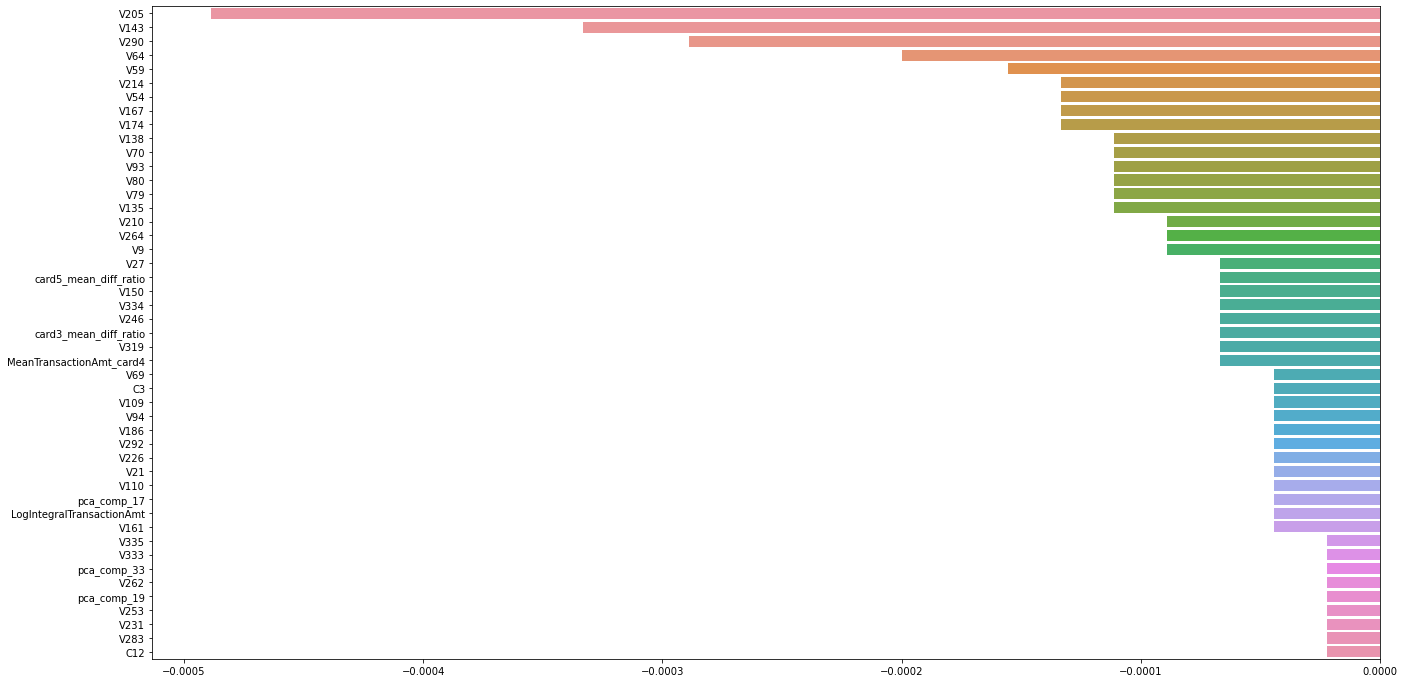

In [132]:
fig, ax = plt.subplots(1, figsize=(22, 12))
g = sns.barplot(x=feature_importances.importances_mean[importance_indices], y=data[ex6].columns[importance_indices])

In [133]:
x_train, x_valid = train_test_split(data.drop(["isFraud"], axis=1), train_size=0.7, random_state=1)
y_train, y_valid = train_test_split(data["isFraud"], train_size=0.7, random_state=1)

dtrain = xgb.DMatrix(x_train[data[ex6].columns[importance_indices]], y_train)
dvalid = xgb.DMatrix(x_valid[data[ex6].columns[importance_indices]], y_valid)

model = xgb.train(
    dtrain=dtrain,
    params=xgb_params,
    num_boost_round=500,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=20,
    verbose_eval=10,
)

[13:54:49] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.74831	valid-auc:0.71558
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[10]	train-auc:0.83269	valid-auc:0.80691
[20]	train-auc:0.85881	valid-auc:0.83068
[30]	train-auc:0.88004	valid-auc:0.84044
[40]	train-auc:0.89211	valid-auc:0.84752
[50]	train-auc:0.90711	valid-auc:0.85133
[60]	train-auc:0.91576	valid-auc:0.85533
[70]	train-auc:0.92404	valid-auc:0.85813
[80]	train-auc:0.93018	valid-auc:0.85991
[90]	train-auc:0.93397	valid-auc:0.86054
[100]	train-auc:0.93785	valid-auc:0.86338
[110]	train-auc:0.94120	valid-auc:0.86421
[120]	train-auc:0.94516	valid-au

In [140]:
importance_indices = np.where(feature_importances.importances_mean <= 0)

In [141]:
x_train, x_valid = train_test_split(data.drop(["isFraud"], axis=1), train_size=0.7, random_state=1)
y_train, y_valid = train_test_split(data["isFraud"], train_size=0.7, random_state=1)

dtrain = xgb.DMatrix(x_train[data[ex6].columns[importance_indices]], y_train)
dvalid = xgb.DMatrix(x_valid[data[ex6].columns[importance_indices]], y_valid)

model = xgb.train(
    dtrain=dtrain,
    params=xgb_params,
    num_boost_round=500,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=20,
    verbose_eval=10,
)

[13:57:20] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.75508	valid-auc:0.73773
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[10]	train-auc:0.84637	valid-auc:0.82073
[20]	train-auc:0.87961	valid-auc:0.86028
[30]	train-auc:0.92737	valid-auc:0.88258
[40]	train-auc:0.95336	valid-auc:0.89771
[50]	train-auc:0.96827	valid-auc:0.90662
[60]	train-auc:0.97654	valid-auc:0.91218
[70]	train-auc:0.98055	valid-auc:0.91417
[80]	train-auc:0.98381	valid-auc:0.91652
[90]	train-auc:0.98637	valid-auc:0.91720
[100]	train-auc:0.98835	valid-auc:0.91811
[110]	train-auc:0.99037	valid-auc:0.91953
[120]	train-auc:0.99243	valid-au

Кажется, что на данном датасете это не особо помогло, но во всяком случае урезание ~ 100 фичей практически не снижает качество на валидации.